In [1]:
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

from src.datasets import SpermDataset

In [2]:
folder_path = r'B:\t4db\SpermSegGS'#r"C:\Users\C0101\PycharmProjects\cc7221\tarea4\data\SpermSegGS"
dataset = SpermDataset(folder_path)

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'C:\\Users\\C0101\\PycharmProjects\\cc7221\\tarea4\\data\\SpermSegGS\\images'

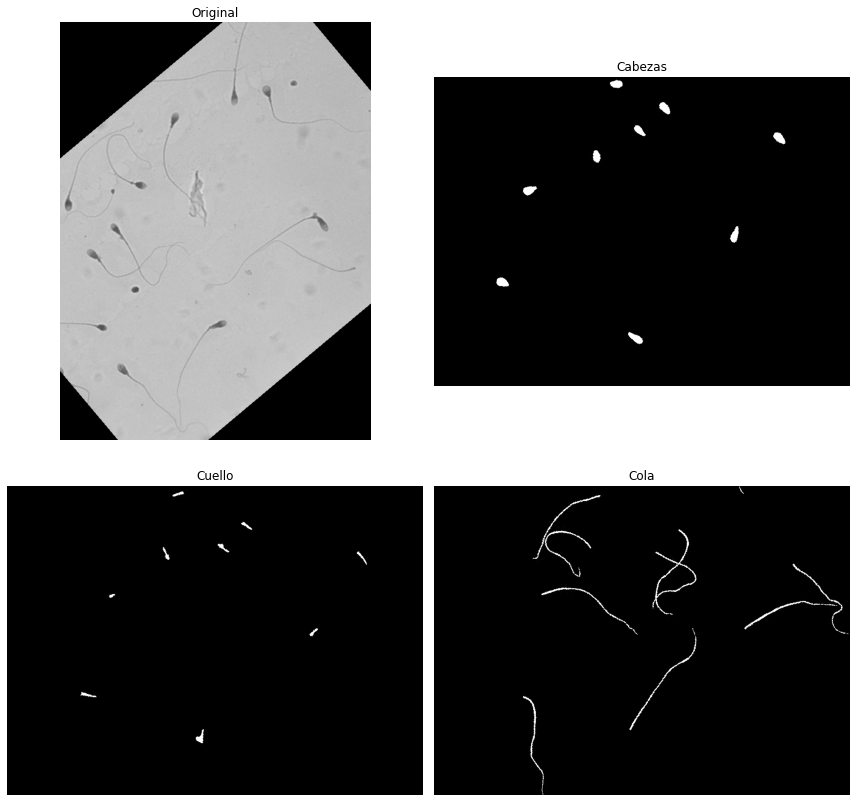

In [3]:
image, mask = dataset[1]
image = image.permute(2, 1, 0)
image = image.detach().cpu().numpy()
mask = mask.detach().cpu().numpy()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs[0][0].imshow(image, cmap='gray')
axs[0][0].set_title("Original")
axs[0][1].imshow(mask[0, :, :], cmap='gray')
axs[0][1].set_title("Cabezas")
axs[1][0].imshow(mask[1, :, :], cmap='gray')
axs[1][0].set_title("Cuello")
axs[1][1].imshow(mask[2, :, :], cmap='gray')
axs[1][1].set_title("Cola")

for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()

In [4]:
import torchvision
import torch

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    """
    copy from: https://github.com/Hsuxu/Loss_ToolBox-PyTorch/blob/master/FocalLoss/FocalLoss.py
    This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
    'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'
        Focal_Loss= -1*alpha*(1-pt)*log(pt)
    :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
    :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
                    focus on hard misclassified example
    :param smooth: (float,double) smooth value when cross entropy
    :param balance_index: (int) balance class index, should be specific when alpha is float
    :param size_average: (bool, optional) By default, the losses are averaged over each loss element in the batch.
    """

    def __init__(self, apply_nonlin=None, alpha=None, gamma=2, balance_index=0, smooth=1e-5, size_average=True):
        super(FocalLoss, self).__init__()
        self.apply_nonlin = apply_nonlin
        self.alpha = alpha
        self.gamma = gamma
        self.balance_index = balance_index
        self.smooth = smooth
        self.size_average = size_average

        if self.smooth is not None:
            if self.smooth < 0 or self.smooth > 1.0:
                raise ValueError('smooth value should be in [0,1]')

    def forward(self, logit, target):
        if self.apply_nonlin is not None:
            logit = self.apply_nonlin(logit)
        num_class = logit.shape[1]

        if logit.dim() > 2:
            # N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            logit = logit.view(logit.size(0), logit.size(1), -1)
            logit = logit.permute(0, 2, 1).contiguous()
            logit = logit.view(-1, logit.size(-1))
        target = torch.squeeze(target, 1)
        target = target.view(-1, 1)
        # print(logit.shape, target.shape)
        #
        alpha = self.alpha

        if alpha is None:
            alpha = torch.ones(num_class, 1)
        elif isinstance(alpha, (list, np.ndarray)):
            assert len(alpha) == num_class
            alpha = torch.FloatTensor(alpha).view(num_class, 1)
            alpha = alpha / alpha.sum()
        elif isinstance(alpha, float):
            alpha = torch.ones(num_class, 1)
            alpha = alpha * (1 - self.alpha)
            alpha[self.balance_index] = self.alpha

        else:
            raise TypeError('Not support alpha type')

        if alpha.device != logit.device:
            alpha = alpha.to(logit.device)

        idx = target.cpu().long()

        one_hot_key = torch.FloatTensor(target.size(0), num_class).zero_()
        one_hot_key = one_hot_key.scatter_(1, idx, 1)
        if one_hot_key.device != logit.device:
            one_hot_key = one_hot_key.to(logit.device)

        if self.smooth:
            one_hot_key = torch.clamp(
                one_hot_key, self.smooth / (num_class - 1), 1.0 - self.smooth)
        pt = (one_hot_key * logit).sum(1) + self.smooth
        logpt = pt.log()

        gamma = self.gamma

        alpha = alpha[idx]
        alpha = torch.squeeze(alpha)
        loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt

        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss



In [25]:
batch_size = 4
n_classes = 3
w, h = 256, 256 # no son estas 
pred = torch.rand((batch_size, n_classes, w, h))
target = torch.randint(high=n_classes, size=(batch_size, w, h))

In [26]:
ce_loss = torch.nn.CrossEntropyLoss()
focal_loss = FocalLoss()

In [27]:
focal_loss(pred, target)

tensor(0.6113)

In [28]:
ce_loss(pred, target)

tensor(1.1263)